
# Human Activity Recognition


**Importing libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!unzip /content/drive/MyDrive/Train_Test_video_classifier.zip -d /content

Originally, the zip file containes a 50-50 split data.
We are going to resplit the data by moving 70% of the validation dataset into the training.

In [2]:
import os
import shutil
Source = '/content/Validation' 
Destination = '/content/Training'
split_num = 0.7
for category in os.listdir(Source):
  images = os.listdir(os.path.join(Source, category))
  num_images = len(images)
  split = int(split_num * num_images)
  for image in images[0: split]: shutil.move(os.path.join(Source, category, image), os.path.join(Destination, category, 'v' + image))

# **Training**
We are going to use a pretrained MobileNet architecture using imagenet as the pretrained model.


Top layers only are trained while the rest are left frozen.


# **Training approach**
In order to classify a single video which is now divided into many images, we will alternatively classify those images and the output label would be the video's class.


Now, we are going to load the images using the ImageDataGenerator and train the image against its label in order to come up with a classification pattern.

In [3]:
# Importing the important libraries
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Download the architecture of ResNet50 with ImageNet weights
base_model = tf.keras.applications.MobileNet(include_top=False, weights="imagenet")

# Taking the output of the last convolution block in ResNet50
x = base_model.output

# Adding a Global Average Pooling layer
x = GlobalAveragePooling2D()(x)

# Adding a fully connected layer having 1024 neurons
x = Dense(512, activation='relu')(x)

# Adding a fully connected layer having 45 neurons which will
# give the probability of image being under 45 classes
predictions = Dense(45, activation='softmax')(x)

# Model to be trained
model = Model(inputs=base_model.input, outputs=predictions)

# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), loss='categorical_crossentropy', metrics = ['accuracy'])

# Creating objects for image augmentations
image_generator = ImageDataGenerator(rescale = 1./255)

# Proving the path of training and test dataset
# Setting the image input size as (224, 224)
# We are using class mode as binary because there are only two classes in our data
training_generator = image_generator.flow_from_directory('/content/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_generator = image_generator.flow_from_directory('/content/Validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

# Training the model for 5 epochs
history = model.fit_generator(training_generator,
                         epochs = 6,
                         verbose=1,
                         validation_data = validation_generator
            )

# Saving the weights in the current directory
model.save_weights("resnet50_weights.h5")


17227776/17225924 [==============================] - 0s 0us/step
Found 74582 images belonging to 45 classes.
Found 13226 images belonging to 45 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
2331/2331 [==============================] - 432s 171ms/step - loss: 0.9238 - accuracy: 0.7587 - val_loss: 0.1434 - val_accuracy: 0.9646
Epoch 2/6
2331/2331 [==============================] - 344s 148ms/step - loss: 0.1158 - accuracy: 0.9587 - val_loss: 0.1563 - val_accuracy: 0.9532
Epoch 3/6
2331/2331 [==============================] - 332s 142ms/step - loss: 0.0908 - accuracy: 0.9629 - val_loss: 0.1371 - val_accuracy: 0.9620
Epoch 4/6
2331/2331 [==============================] - 329s 141ms/step - loss: 0.0768 - accuracy: 0.9660 - val_loss: 0.0910 - val_accuracy: 0.9739
Epoch 5/6
2331/2331 [==============================] - 327s 140ms/step - loss: 0.0683 - accuracy: 0.9676 - val_loss: 0.1106 - val_accuracy: 0.9688
Epoch 6/6
2331/2331 [==============================] - 327s 140ms/step - loss: 0.0660 - accuracy: 0.9681 - val_loss: 0.1287 - val_accuracy: 0.9654


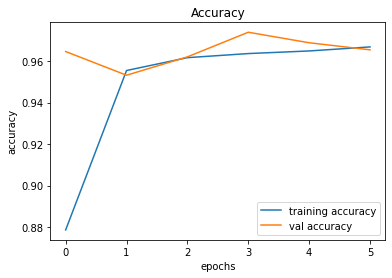

In [5]:
# accuracy
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

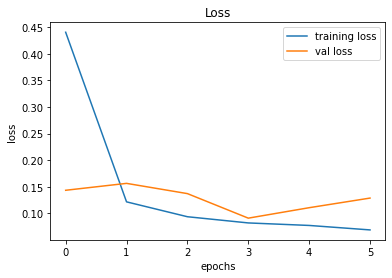

In [6]:

# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()